#### B+树

B+ 树的特点：
* 每个节点中子节点的个数不能超过 m，也不能小于 m/2；
* 根节点的子节点个数可以不超过 m/2，这是一个例外；
* m 叉树只存储索引，并不真正存储数据，这个有点儿类似跳表；
* 通过链表将叶子节点串联在一起，这样可以方便按区间查找；
* 一般情况，根节点会被存储在内存中，其他节点存储在磁盘中。

B-树
* 实际上是低级版的 B+ 树，或者说 B+ 树是 B 树的改进版。
* B 树跟 B+ 树的不同点主要集中在这几个地方：
  * B+ 树中的节点不存储数据，只是索引，而 B 树中的节点存储数据；
  * B 树中的叶子节点并不需要链表来串联。

Q:B+ 树中，将叶子节点串起来的链表，是单链表还是双向链表？为什么？
A: 对于B+tree叶子节点，是用双向链表还是用单链表，得从具体的场景思考。我想，大部分同学在开发中遇到的数据库查询，都遇到过升序或降序问题，即类似这样的sql: select name,age, ... from where uid > startValue and uid < endValue order by uid asc(或者desc)，此时，数据底层实现有两种做法：
1）保证查出来的数据就是用户想要的顺序
2）不保证查出来的数据的有序性，查出来之后再排序
以上两种方案，不加思考，肯定选第一种，因为第二种做法浪费了时间（如果选用内存排序，还是考虑数据的量级）。那如何能保证查询出来的数据就是有序的呢？单链表肯定做不到，只能从头往后遍历，再想想，只能选择双向链表了。此时，可能有的同学又问了：双向链表，多出来了一倍的指针，不是会多占用空间嘛？  答案是肯定的。可是，我们再细想下，数据库索引本身都已经在磁盘中了，对于磁盘来说，这点空间已经微不足道了，用这点空间换来时间肯定划算呀。顺便提一下：在实际工程应用中，双向链表应用的场景非常广泛，毕竟能大量减少链表的遍历时间



Q: 我们对平衡二叉查找树进行改造，将叶子节点串在链表中，就支持了按照区间来查找数据。我们在散列表（下）讲到，散列表也经常跟链表一块使用，如果我们把散列表中的结点，也用链表串起来，能否支持按照区间查找数据呢？
A: 答案是「肯定的」。如同@老杨 大哥说的，JDK中的LinkedHashMap为了能做到保持节点的顺序（插入顺序或者访问顺序），就是用双向链表将节点串起来的

--------

select * from user where id > 1234 and id < 2345

让二叉查找树支持按区间来查找数据，对其进行改造
* 树中的节点并不存储数据本身，而是只是作为索引
* 把每个叶子节点串在一条链表上，链表中的数据是从小到大有序的
* 要求某个区间的数据，只需要拿区间的起始值，在树中进行查找，当查找到某个叶子节点之后，再顺着链表往后遍历，直到链表中的结点数据值大于区间的终止值为止。
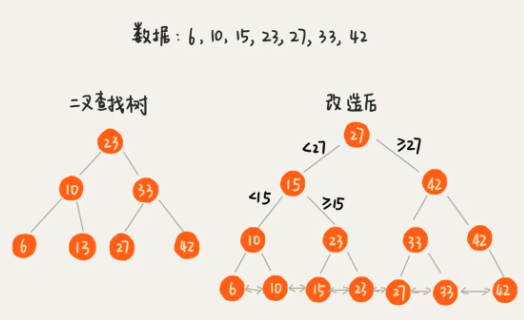

假设给一亿个数据构建二叉查找树索引，那索引中会包含大约 1 亿个节点，每个节点假设占用 16 个字节，那就需要大约 1GB 的内存空间。给一张表建立索引，需要 1GB 的内存空间。如果要给 10 张表建立索引，那对内存的需求是无法满足的

##### 解决索引占用内存过多的问题

将索引存储到硬盘上
* 可以借助时间换空间的思路，把索引存储在硬盘中，而非内存中。
* 硬盘是一个非常慢速的存储设备。通常内存的访问速度是纳秒级别的，而磁盘访问的速度是毫秒级别的。读取同样大小的数据，从磁盘中读取花费的时间，是从内存中读取所花费时间的上万倍，甚至几十万倍。
* 每个节点的读取（或者访问），都对应一次磁盘 IO 操作。树的高度就等于每次查询数据时磁盘 IO 操作的次数。
将索引构建成 `m叉树` ，降低树的高度，减少磁盘操作
* 给 16 个数据构建二叉树索引，树的高度是 4，查找一个数据，就需要 4 个磁盘 IO 操作（如果根节点存储在内存中，其他节点存储在磁盘中）
* 如果对 16 个数据构建五叉树索引，那高度只有 2，查找一个数据，对应只需要 2 次磁盘操作
* 如果 m 叉树中的 m 是 100，那对一亿个数据构建索引，树的高度也只是 3，最多只要 3 次磁盘 IO 就能获取到数据。磁盘 IO 变少了，查找数据的效率也就提高了。

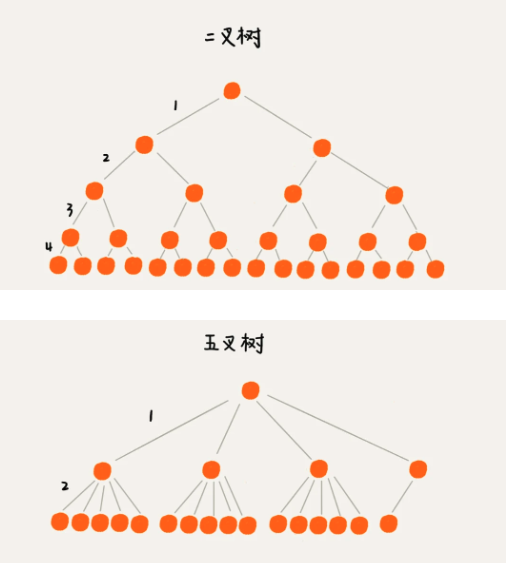

~~~

/**
 * 这是B+树非叶子节点的定义。
 *
 * 假设keywords=[3, 5, 8, 10]
 * 4个键值将数据分为5个区间：(-INF,3), [3,5), [5,8), [8,10), [10,INF)
 * 5个区间分别对应：children[0]...children[4]
 *
 * m值是事先计算得到的，计算的依据是让所有信息的大小正好等于页的大小：
 * PAGE_SIZE = (m-1)*4[keywordss大小]+m*8[children大小]
 */
public class BPlusTreeNode {
  public static int m = 5; // 5叉树
  public int[] keywords = new int[m-1]; // 键值，用来划分数据区间
  public BPlusTreeNode[] children = new BPlusTreeNode[m];//保存子节点指针
}

/**
 * 这是B+树中叶子节点的定义。
 *
 * B+树中的叶子节点跟内部节点是不一样的,
 * 叶子节点存储的是值，而非区间。
 * 这个定义里，每个叶子节点存储3个数据行的键值及地址信息。
 *
 * k值是事先计算得到的，计算的依据是让所有信息的大小正好等于页的大小：
 * PAGE_SIZE = k*4[keyw..大小]+k*8[dataAd..大小]+8[prev大小]+8[next大小]
 */
public class BPlusTreeLeafNode {
  public static int k = 3;
  public int[] keywords = new int[k]; // 数据的键值
  public long[] dataAddress = new long[k]; // 数据地址

  public BPlusTreeLeafNode prev; // 这个结点在链表中的前驱结点
  public BPlusTreeLeafNode next; // 这个结点在链表中的后继结点
}

~~~


m 的选择：
* 不管是内存中的数据，还是磁盘中的数据，`操作系统都是按页（一页大小通常是 4KB，这个值可以通过 getconfig PAGE_SIZE 命令查看）来读取的，一次会读一页的数据`。
* 如果要读取的数据量超过一页的大小，就会触发多次 IO 操作。
* 所以，在选择 m 大小的时候，要尽量让每个节点的大小等于一个页的大小。读取一个节点，只需要一次磁盘 IO 操作。
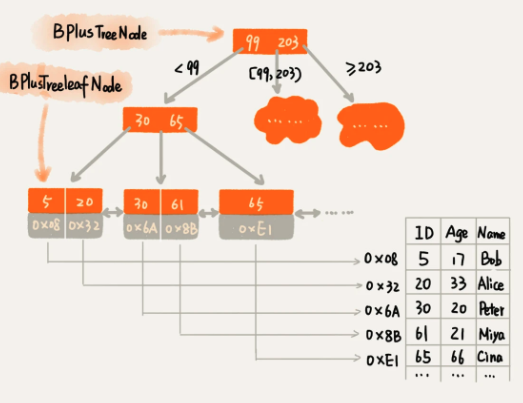

索引的弊端：
* 数据的写入、删除的过程，会涉及索引的更新，这是索引导致写入变慢的主要原因。
  
索引的调整：
1. 写入数据
* 对于一个 B+ 树来说，m 值是根据页的大小事先计算好的，也就是说，每个节点最多只能有 m 个子节点。在往数据库中写入数据的过程中，这样就有可能使索引中某些节点的子节点个数超过 m，这个节点的大小超过了一个页的大小，读取这样一个节点，就会导致多次磁盘 IO 操作。
* 只需要将这个节点分裂成两个节点。但是，节点分裂之后，其上层父节点的子节点个数就有可能超过 m 个。不过这也没关系，我们可以用同样的方法，将父节点也分裂成两个节点。这种级联反应会从下往上，一直影响到根节点。
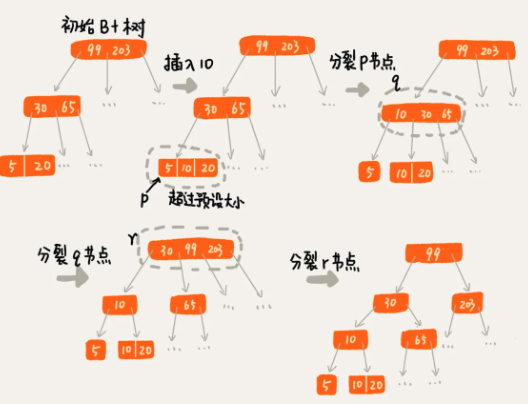
（图中的 B+ 树是一个三叉树。我们限定叶子节点中，数据的个数超过 2 个就分裂节点；非叶子节点中，子节点的个数超过 3 个就分裂节点）

2. 删除数据
* 可以设置一个阈值。在 B+ 树中，这个阈值等于 m/2。如果某个节点的子节点个数小于 m/2，我们就将它跟相邻的兄弟节点合并。不过，合并之后节点的子节点个数有可能会超过 m。针对这种情况，我们可以借助插入数据时候的处理方法，再分裂节点。
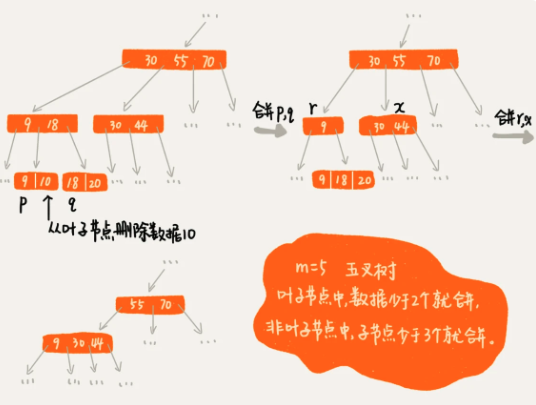
（图中的 B+ 树是一个五叉树。我们限定叶子节点中，数据的个数少于 2 个就合并节点；非叶子节点中，子节点的个数少于 3 个就合并节点。）
   



#### 跳表

B+ 树的结构和操作，跟跳表非常类似。理论上讲，对跳表稍加改造，也可以替代 B+ 树，作为数据库的索引实现的。
B+ 树发明于 1972 年，跳表发明于 1989 年，我们可以大胆猜想下，跳表的作者有可能就是受了 B+ 树的启发，才发明出跳表来的。不过，这个也无从考证了。